# Hungarian Multi Rings

**Goal:** In the past notebooks
- `SA-mini`
- `SA-warm-up`

I've been focusing on a single ring to stay in a good range for the hyperparameters.

**Now:** Really understand what `scipy.optimize.linear_sum_assignment` function is doing.

I think the setup that I had from the earlier notebooks should be ok, but it's just a bit of syntax to follow-up on now :)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn.functional as F

from scipy.optimize import linear_sum_assignment

import os
os.sys.path.append('code')
from model import build_grid,SoftPositionalEmbed

%load_ext autoreload
%autoreload 2

### Modifying the Flo's generation

In [8]:
nPixels = 32

xlow = -0.5
xhigh = 0.5
binWidth = (xhigh-xlow)/(nPixels+1)

stdlow = 0.01
stdhigh = 0.05

bins = np.arange(xlow,xhigh,binWidth)

nBins = len(bins)-1

In [9]:
def make_batch(
    bins=np.arange(xlow,xhigh,binWidth),
    N_events = 100000,
    N_clusters = 1,
    mean_var_cluster = np.log(0.001),
    sigma_var_cluster = 0.1,
    mean_lam_cluster = np.log(200.),
    sigma_lam_cluster = 1.,
    isRing=True,
    blurImage=False,
    xlow=-.5,
    xhigh=0.5,
    stdlow=0.01,
    stdhigh=0.05,
    device='cpu'
):
    '''
    Starts from Florian's `gen_events` function
    https://gitlab.lrz.de/neural_network_clustering/permutation_invariant_loss/-/blob/main/test_blur.ipynb
    
    But I wanted to return the occupancy maps that you multiply the OG image by to output partitioning
    of the image into the OG ring signals.
    '''

    eventHistograms = np.zeros(shape=(N_events, len(bins)-1, len(bins)-1,1) ) 
    
    eventMasks = np.zeros(shape=(N_events, N_clusters, len(bins)-1, len(bins)-1) ) 
    
    eventNumbers = np.zeros(N_events)

    nMaxClusters = N_clusters   
    
    eventInfo = np.zeros(shape=(N_events, nMaxClusters, 3))
    
    for iEvent in range(N_events):
        
        image = np.zeros_like(eventHistograms[iEvent,:,:,0])
        
        n_clusters = nMaxClusters

        eventNumbers[iEvent] += n_clusters
        eI = []
        
        for iCluster in range(min(n_clusters,nMaxClusters)):
            
            # how many events in this cluster
            lam_N_events_in_cluster = 200. 
            
            N_events_in_cluster = np.random.poisson(lam_N_events_in_cluster)

            # where is the cluster center
            cluster_center = np.random.uniform(low=xlow, high=xhigh, size=2)

            # what is the cluster spread
            var_cluster = np.random.uniform(stdlow,stdhigh) 
            
            cluster_events_x0 = np.random.normal(loc=0., scale=1., size=N_events_in_cluster)
            cluster_events_y0 = np.random.normal(loc=0., scale=1., size=N_events_in_cluster)

            if isRing:
                fact = np.sqrt(var_cluster/(cluster_events_x0**2+cluster_events_y0**2))
            else:
                fact = np.sqrt(var_cluster)

            cluster_events_x = cluster_events_x0*fact + cluster_center[0]
            cluster_events_y = cluster_events_y0*fact + cluster_center[1]
            
            # bin the events
            H, _, _ = np.histogram2d(cluster_events_x, cluster_events_y, bins=[bins,bins])

            eventMasks[iEvent,iCluster] = H.T
            image += H.T
                        
            eI.append(np.concatenate([cluster_center, [var_cluster]]))

        eventHistograms[iEvent,:,:,0] = np.copy(image)

        eventInfo[iEvent] = np.array(eI)
    
    # reshape eventHistograms
    eventHistograms = eventHistograms[:,None,:,:,0] # shape (bs, 1, nPixels, nPixels)
    
    eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)
    
    return torch.FloatTensor(eventHistograms).to(device), \
           torch.FloatTensor(eventInfo).to(device), \
           torch.FloatTensor(eventMasks).to(device)

Let's consider:
- batch_size 4
- 2 rings
- 3 slots

In [10]:
max_n_rings = 1
device='cuda:0'

In [11]:
bs=2
X, Y, true = make_batch(bins, N_events=bs, N_clusters=max_n_rings,device=device)

<ipython-input-9-30a9e9839aa9>:83: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [13]:
iEvt=1

if max_n_rings>1:
    fig, axs = plt.subplots(1,max_n_rings,figsize=(max_n_rings*3+1,3))

    for i,ax in enumerate(axs):

        im = ax.imshow(true[iEvt,i].cpu().numpy(),vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(f'Truth photon {i}')

        ax.axis('off')

    plt.show()

**Define the model**

In [14]:
from torch.nn import init

In [15]:
k_slots=max_n_rings+1

In [16]:
class SlotAttentionPosEmbed(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 k_slots=3, 
                 hidden_dim=32, 
                 query_dim=32, 
                 n_iter=2,
                 device='cpu' 
                 ):
        '''
        Slot attention encoder block with positional embedding

        Inputs:
        - device (cpu, mps, cuda): Which device to put the model on 
                (needed for the random call when initializing the slots)
        - k_slots: number of slots (note, can vary between training and test time)
        - hidden_dim: The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - query_dim: The latent space dimension that the slots and the queries get computed in
        - n_iter: Number of slot attention steps to apply (defualt 2, and rn hard coded)
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.device=device
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        filter_size=5
        self.CNN_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
        )
        
        self.posEnc = SoftPositionalEmbed(hidden_dim, resolution,device)
        
        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim)
        )
        
#         self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))

#         self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
#         init.xavier_uniform_(self.slots_logsigma)
    
            
    def init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim).to(self.device)
        
        mu = torch.zeros(1,1,self.query_dim).to(self.device)
        logsigma = torch.zeros(1,1,self.query_dim).to(self.device)
        
        return mu + noise*logsigma.exp()


#     def init_slots(self,Nbatch):
#         '''
#         Slot init taken from
#         https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
#         '''
#         mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
#         sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)

#         return mu + sigma * torch.randn(mu.shape).to(self.device)

    def encoder(self,data):
        
        # Apply the CNN encoder
        encoded_data = self.CNN_encoder(data)
        
        # Put the channel dim at the end
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
                 
        # Add the positional embeddings
        encoded_data = self.posEnc(encoded_data)
        
        # Flatten the pixel dims and apply the data normalization + MLP
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        encoded_data = self.init_mlp(encoded_data)
        
        return encoded_data
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients.append( grad )
    
    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        # logits = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) * 10
        logits = torch.einsum('bse,bde->bsd',queries,keys) / self.query_dim 
        
        att = torch.nn.functional.softmax(logits, dim = 1)

        if att.requires_grad:
            h = logits.register_hook(self.activations_hook)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, k_slots, query_dim)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        # att: (bs, k_slots, img_dim)
        # wts: (bs, k_slots, img_dim)
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return updates.reshape(queries.shape)
        
    def forward(self, data):

        self.gradients = []
        
        Nbatch = data.shape[0]
        
        # Initialize the queries
        queries = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
        
        encoded_data = self.encoder(data)
        
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        return queries, att #.reshape(-1,self.k_slots,nPixels,nPixels)
    

**Make a nice plotting function**

In [17]:
def plot_kslots(losses, mask, att, k_slots, color='C2',cmap='Greens'):
    
    fig, axs = plt.subplots(1,k_slots+2,figsize=(2.75 * (k_slots + 2) ,2.5))

    axs[0].plot(losses,color=color)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    
    imgs   = [mask] + [att[i] for i in range(k_slots)]
    titles = ['Target']+[f'Slot {i}' for i in range(k_slots)]
    
    for i, (ax,img,title) in enumerate(zip(axs[1:],imgs, titles)):
        
        im = ax.imshow(img,cmap=cmap,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)

        ax.axis('off')
        
    plt.show()

Train the model!!

In [18]:
def hungarian_matching(att, mask,bs, k_slots,max_n_rings,nPxiels):
    '''
    Hungarian section Translated from the TensorFlow loss function (from 2006.15055 code):
    https://github.com/nhartman94/google-research/blob/master/slot_attention/utils.py#L26-L57
    '''
    
    flat_mask = mask.reshape(-1,max_n_rings, nPixels*nPixels)[:,None,:,:]
    
    att_ext  = torch.tile(att,  dims=(1,1,max_n_rings,1)).reshape(bs * k_slots * max_n_rings , nPixels**2)
    mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)).reshape(bs * k_slots * max_n_rings , nPixels**2)
    
    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    pairwise_cost = pairwise_cost.reshape(bs, k_slots, max_n_rings)
    
    indices = list(map(linear_sum_assignment, pairwise_cost.cpu()))
    indices = torch.LongTensor(indices)
    return indices
    


In [19]:
def train(model, Ntrain = 5000, bs=32, device='cpu', color='C2',cmap='Greens'):
    '''
    train
    -----------
    
    - model
    - Ntrain: # of training iterations
    - color,cmap -- options that get passed the
    '''

    # Learning rate schedule config
    base_learning_rate = 3e-4
    
    decay_rate = 0.5
    warmup_steps=1_000
    decay_steps = 2_000
    
    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    model.train()
    losses = []
    
    for i in range(Ntrain):

        learning_rate = base_learning_rate * decay_rate ** (i / decay_steps)
        # if i < warmup_steps:
        #     learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(N_events=bs, N_clusters=max_n_rings,device=device)
        
        queries, att = model(X)
            
        with torch.no_grad():
            indices = hungarian_matching(att,mask,bs,model.k_slots,max_n_rings,nPixels)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        
        flat_mask = mask.reshape(-1,max_n_rings, nPixels*nPixels)
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        # Calculate the loss
        loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()

        loss.backward()
        opt.step()
        opt.zero_grad()

        losses.append(float(loss))
        
        if i % 50 == 0:
            print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            att_img = att[iEvt].reshape(model.k_slots,nPixels,nPixels)
            plot_kslots(losses, 
                        mask[iEvt].sum(axis=0).detach().cpu().numpy(), 
                        att_img.detach().cpu().numpy(),
                        k_slots, color=color,cmap=cmap)
            
            
            plot_kslots_iters(model, X, iEvt=0)
            plot_kslots_grads(model.gradients,iEvt=0)

    model.eval()
    return model,losses

In [20]:
def plot_kslots_iters(model, data, iEvt, color='C2',cmap='Greens'):
    '''
    Plot the attention masks across the iterations
    '''
    
    n_iter = model.n_iter
    k_slots = model.k_slots
    
    attn_masks = []

    with torch.no_grad():
        # Run through the model code to eval the attn masks
        queries = model.init_slots(data.shape[0]) 
        encoded_data = model.encoder(data)

        for i in range(n_iter):
            # Get the mask
            att,wts = model.attention_and_weights(model.queryN(queries), encoded_data) 
            attn_masks.append(att.detach().cpu())

            # Get the updated query
            queries = model.iterate(queries, encoded_data)

        # Get the final mask
        att,wts = model.attention_and_weights(model.queryN(queries), encoded_data) 
        attn_masks.append(att.detach().cpu())
    
    '''
    Make the plot
    '''
    fig, axs = plt.subplots(n_iter+1,k_slots,figsize=(2.75*k_slots,2.5*(n_iter+1)))
 
    for i, (ax_i, att) in enumerate(zip(axs, attn_masks)):
        
        att_img = att[iEvt].reshape(k_slots,nPixels,nPixels)
        
        for j, (ax, img) in enumerate(zip(ax_i,att_img)):
        
            im = ax.imshow(img,cmap=cmap)#,vmin=0,vmax=1)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')

            ax.set_title(f'T={i}: Slot {j}')

            ax.axis('off')
        
    plt.show()

In [21]:
def plot_kslots_grads(grads, iEvt, color='C2',cmap='Greens'):
    '''
    Plot the gradients across the attention maps
    '''
    
    n_iter = model.n_iter
    k_slots = model.k_slots
    
    '''
    Make the plot
    '''
    fig, axs = plt.subplots(n_iter+1,k_slots,figsize=(2.75*k_slots,2.5*(n_iter+1)))
 
    for i, ax_i, att in zip(range(n_iter+1)[::-1],axs, grads):
        
        att_img = att[iEvt].reshape(k_slots,nPixels,nPixels)
        
        for j, (ax, img) in enumerate(zip(ax_i,att_img)):
        
            im = ax.imshow(img.cpu().numpy(),cmap=cmap)#,vmin=0,vmax=1)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')

            ax.set_title(f'T={i}: Grad attn {j}')

            ax.axis('off')
        
    plt.show()

In [22]:
# plot_kslots_grads(model.gradients,0)

<ipython-input-9-30a9e9839aa9>:83: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)
<ipython-input-18-df10a8c9bd3b>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/torch/csrc/utils/tensor_new.cpp:201.)
  indices = torch.LongTensor(indices)


iter 0 , loss 0.6805965 , lr 0.0003


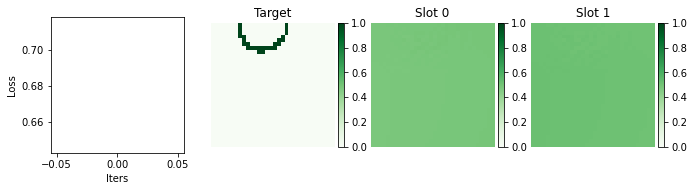

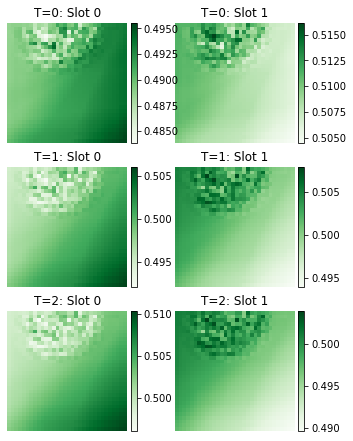

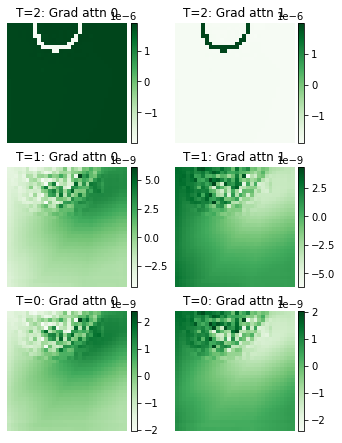

iter 50 , loss 0.527894 , lr 0.0002948461795635753


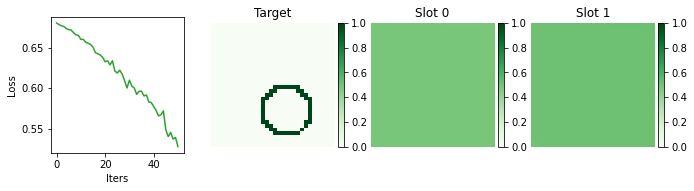

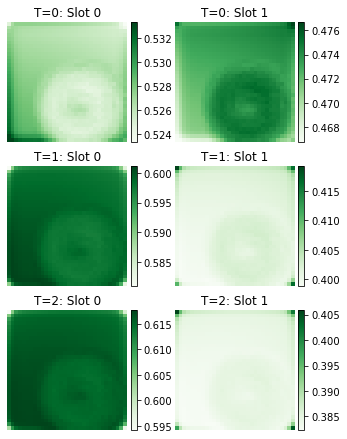

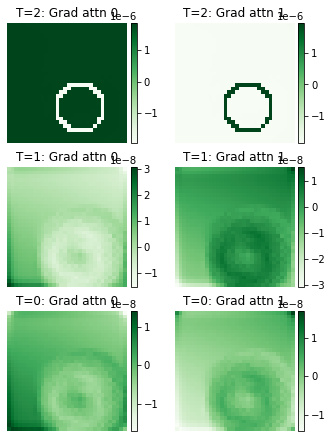

iter 100 , loss 0.30043817 , lr 0.00028978089867745364


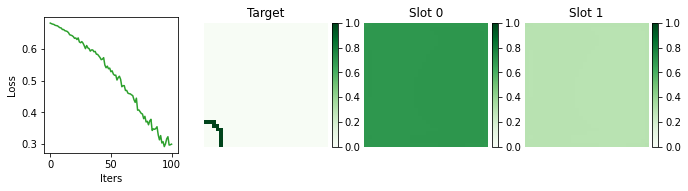

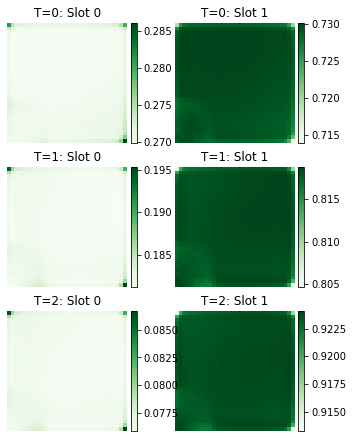

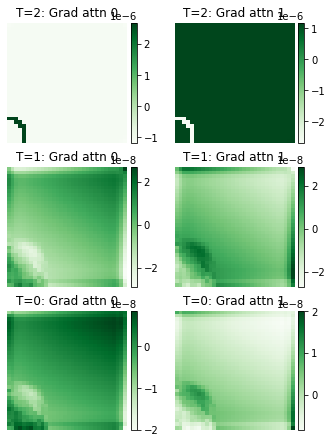

iter 150 , loss 0.2543458 , lr 0.0002848026362851557


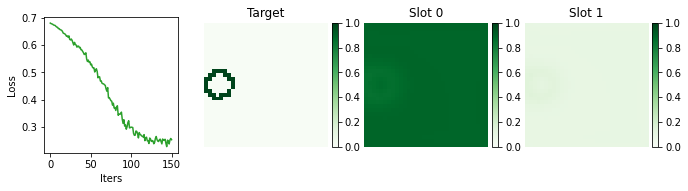

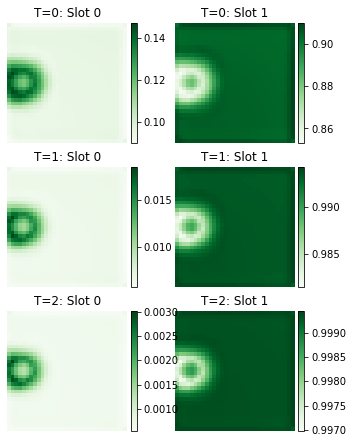

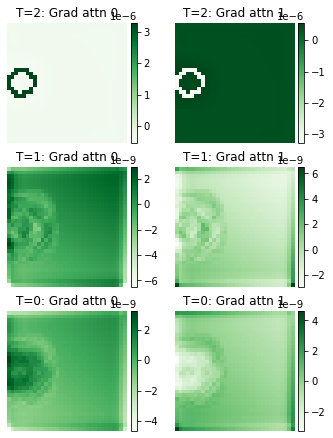

iter 200 , loss 0.09681323 , lr 0.0002799098974610422


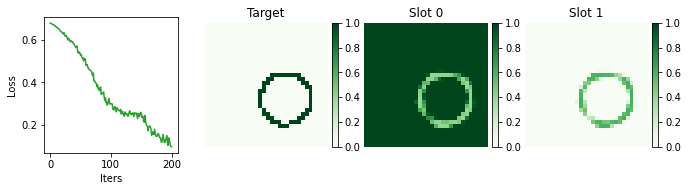

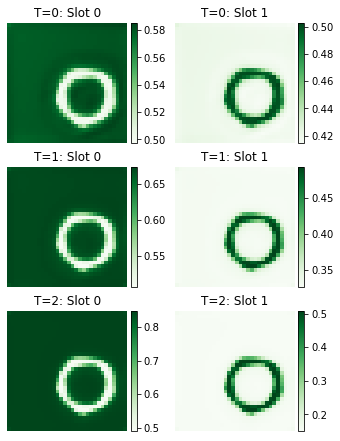

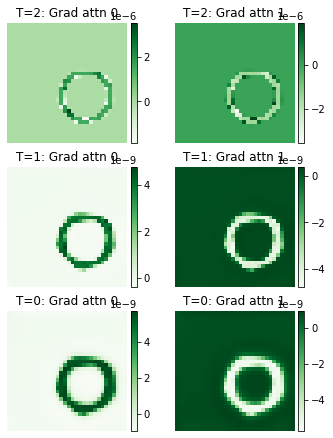

iter 250 , loss 0.05332838 , lr 0.0002751012129614013


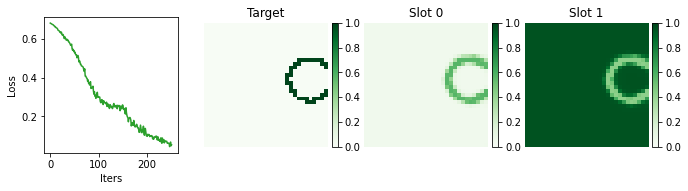

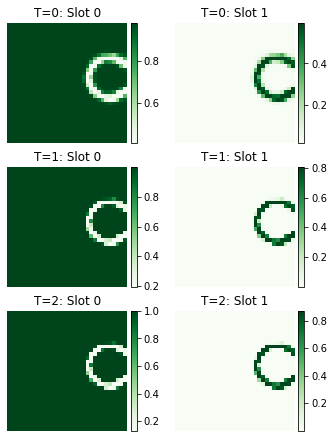

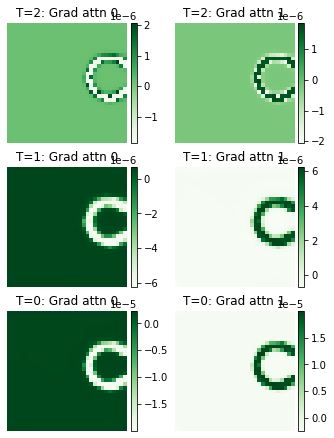

iter 300 , loss 0.030125583 , lr 0.00027037513878324905


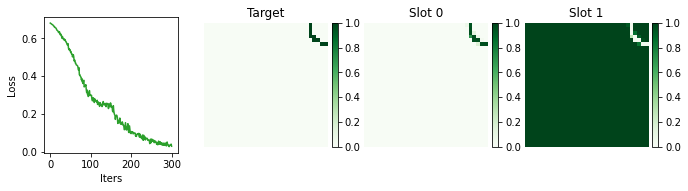

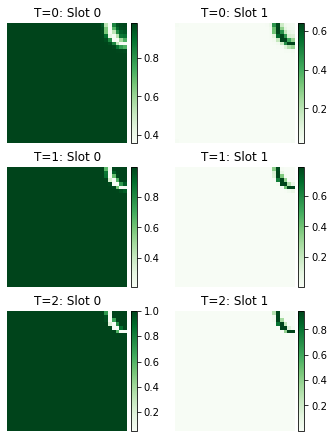

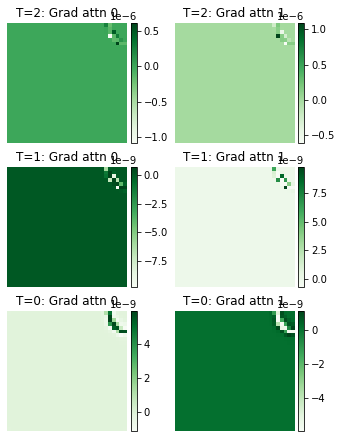

iter 350 , loss 0.0242531 , lr 0.00026573025573070814


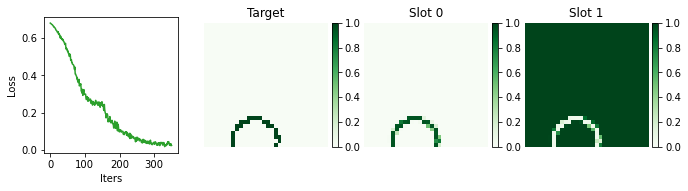

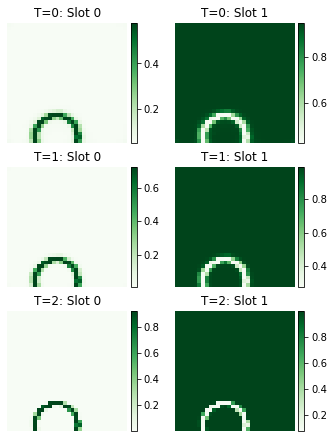

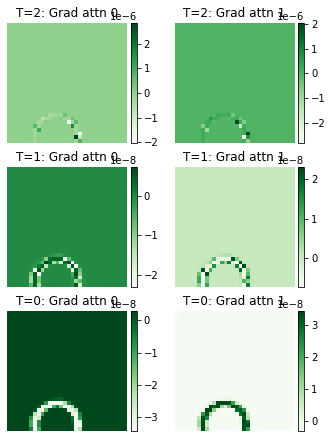

iter 400 , loss 0.015128288 , lr 0.0002611651689888372


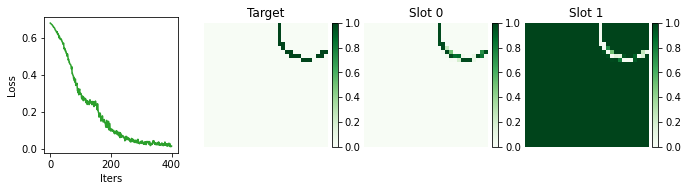

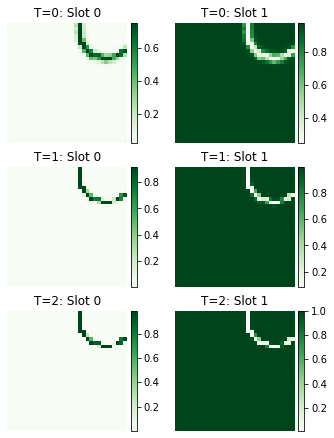

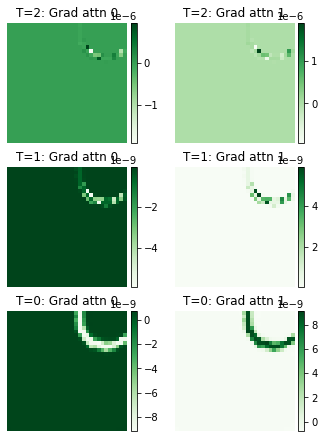

iter 450 , loss 0.015963381 , lr 0.0002566785077047806


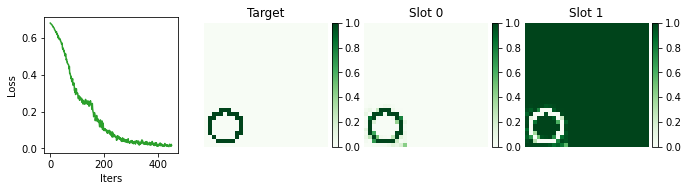

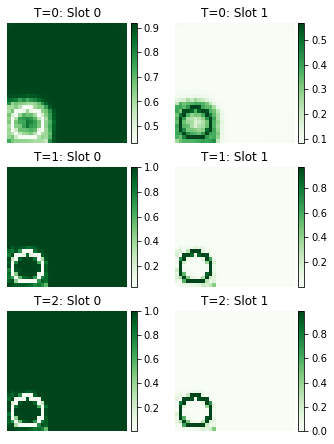

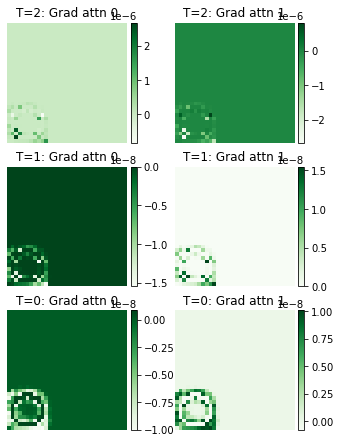

iter 500 , loss 0.016171442 , lr 0.00025226892457611434


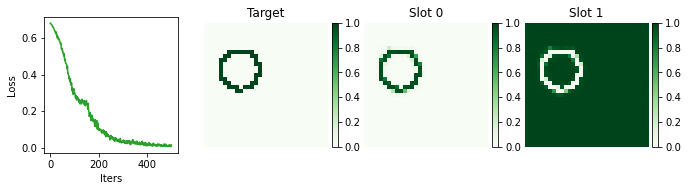

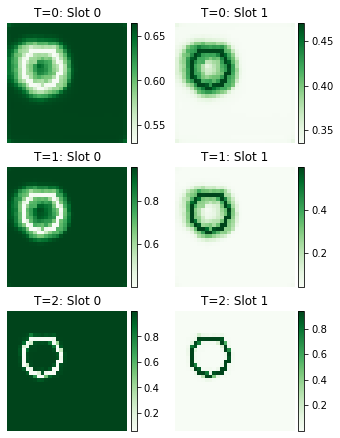

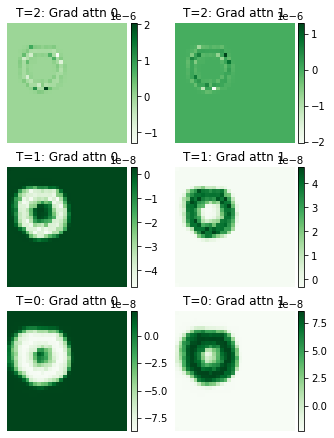

iter 550 , loss 0.012510493 , lr 0.0002479350954462635


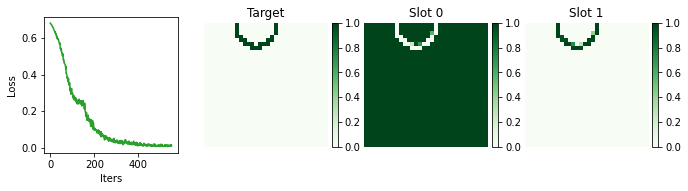

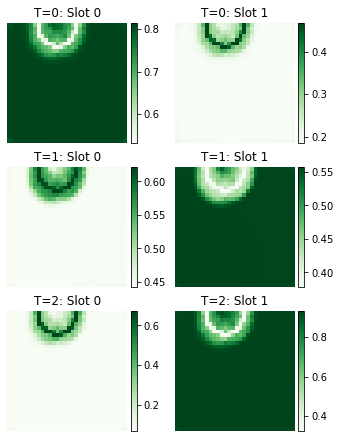

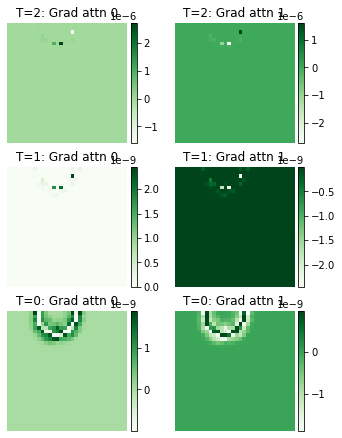

iter 600 , loss 0.0057245083 , lr 0.00024367571890687067


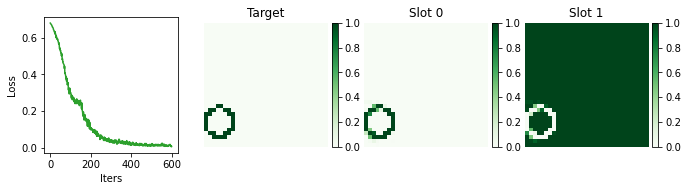

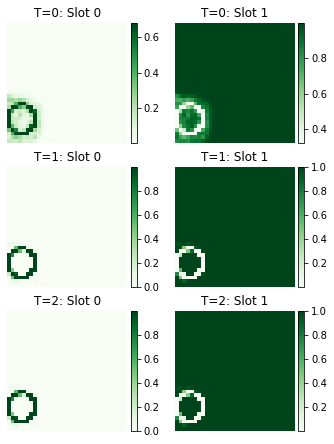

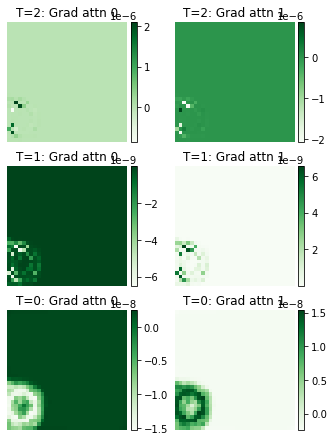

iter 650 , loss 0.017074522 , lr 0.00023948951590699492


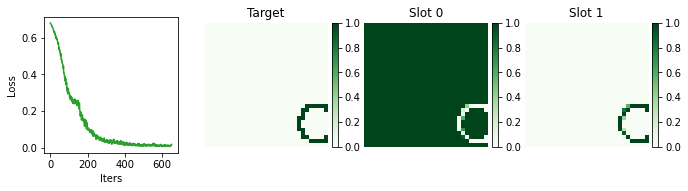

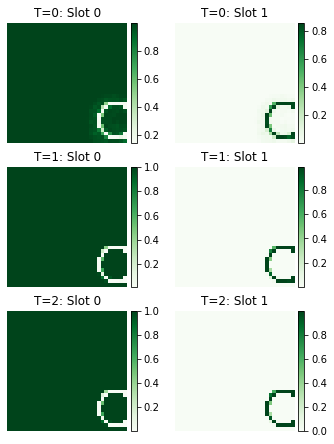

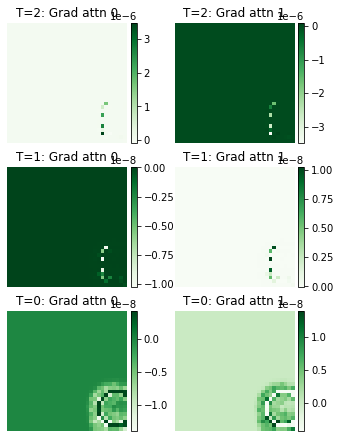

iter 700 , loss 0.003827352 , lr 0.0002353752293690252


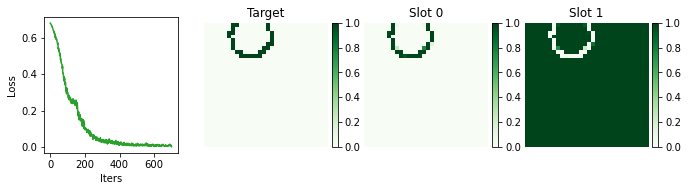

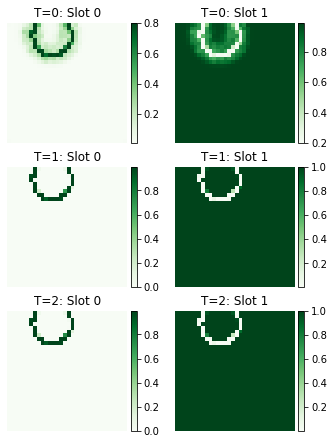

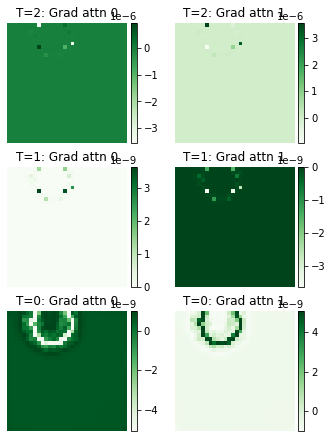

iter 750 , loss 0.0060929777 , lr 0.00023133162381119108


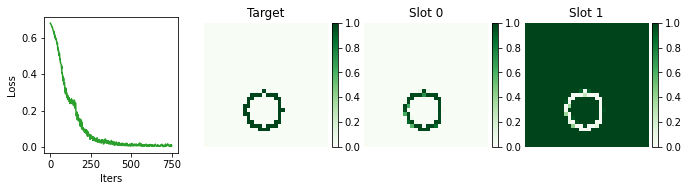

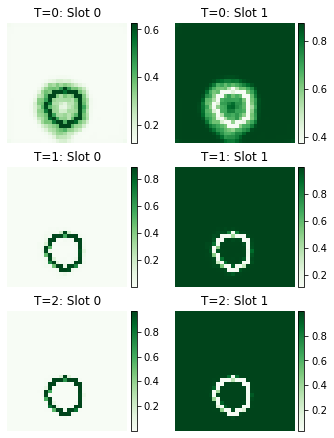

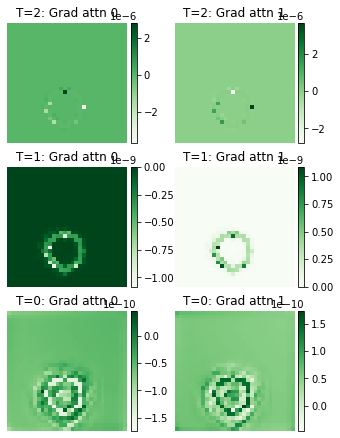

iter 800 , loss 0.0064387354 , lr 0.00022735748497655967


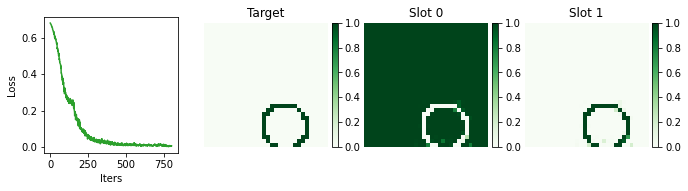

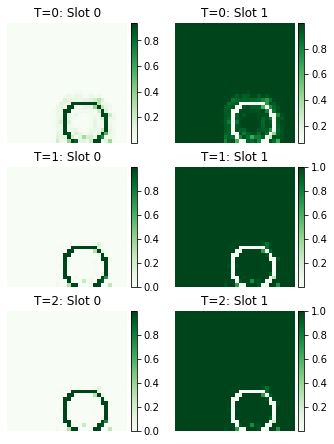

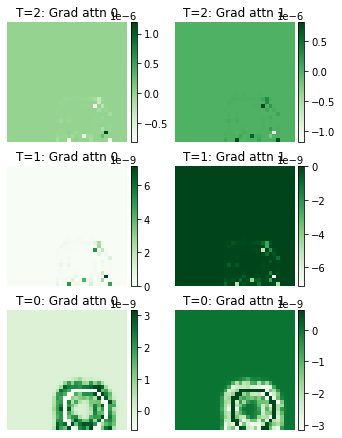

iter 850 , loss 0.007528449 , lr 0.00022345161946840534


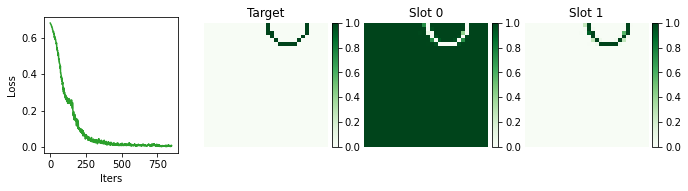

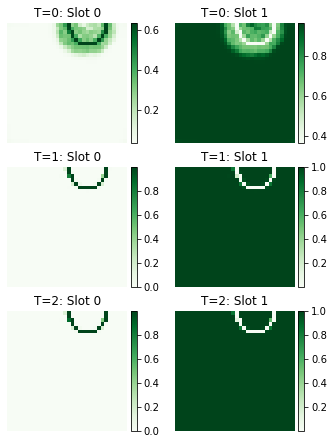

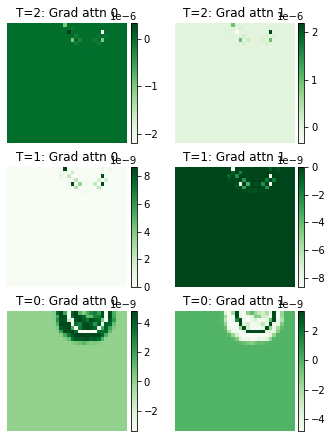

iter 900 , loss 0.0052973237 , lr 0.00021961285439184378


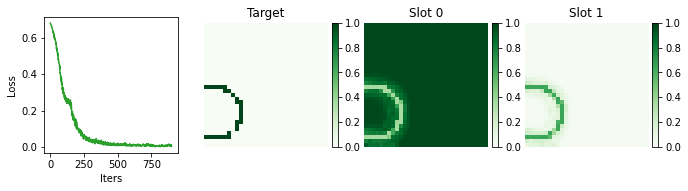

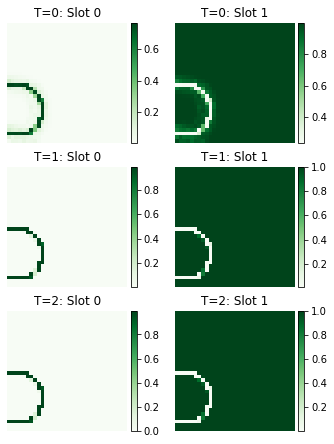

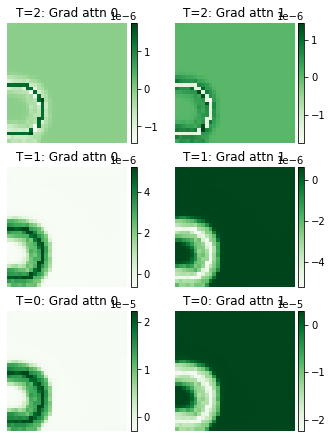

iter 950 , loss 0.012605848 , lr 0.00021584003700162298


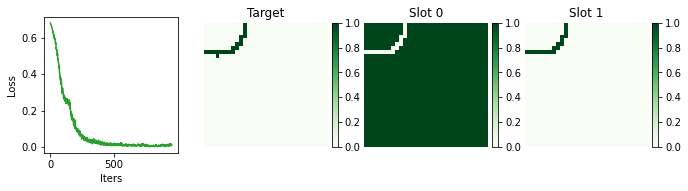

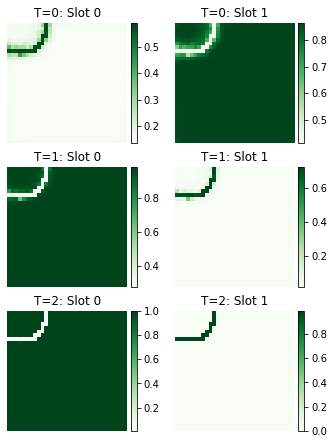

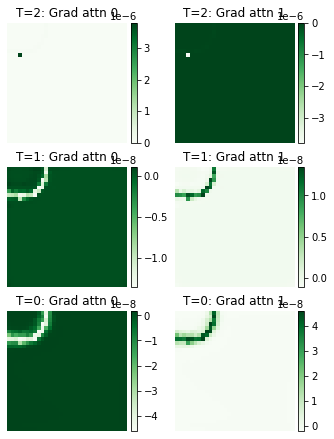

iter 1000 , loss 0.013385221 , lr 0.00021213203435596425


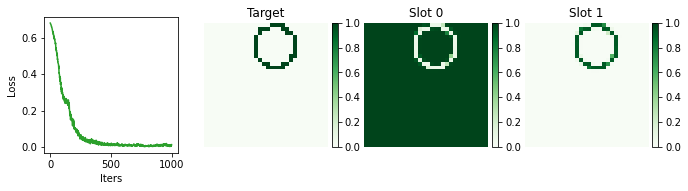

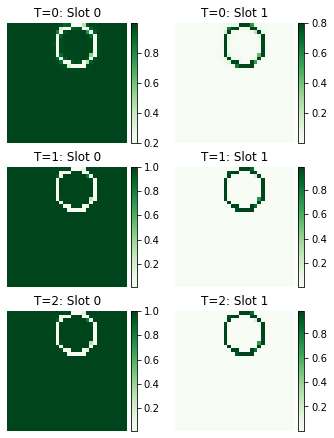

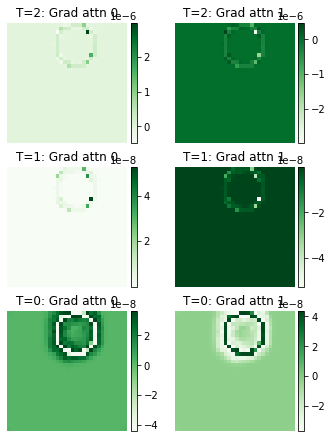

iter 1050 , loss 0.008476604 , lr 0.00020848773297635052


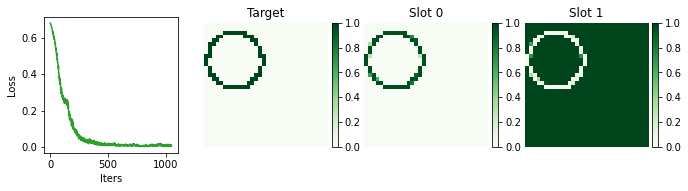

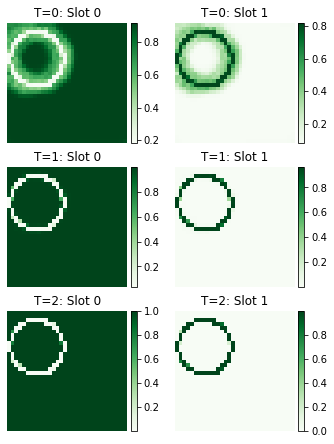

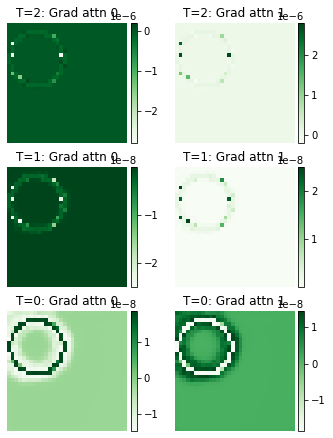

iter 1100 , loss 0.008505938 , lr 0.0002049060385131593


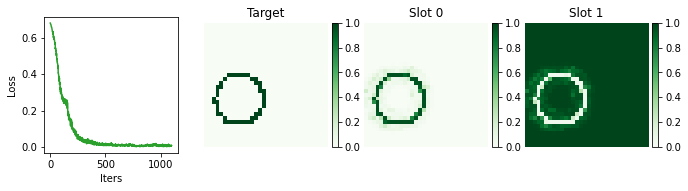

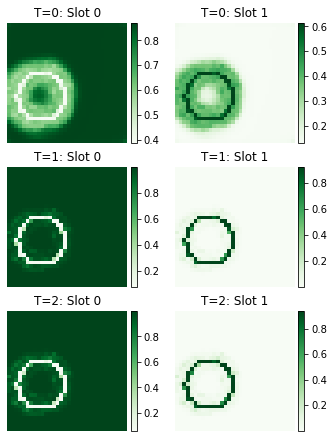

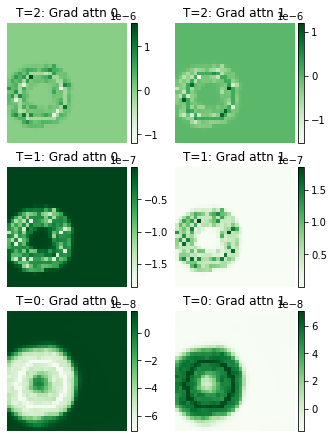

iter 1150 , loss 0.011813409 , lr 0.0002013858754170395


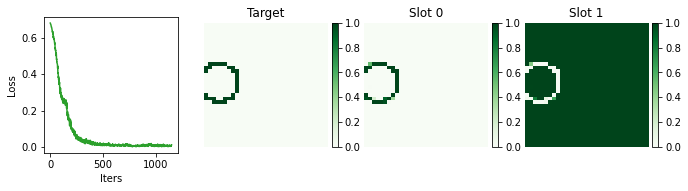

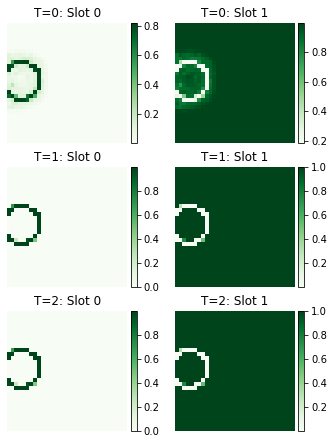

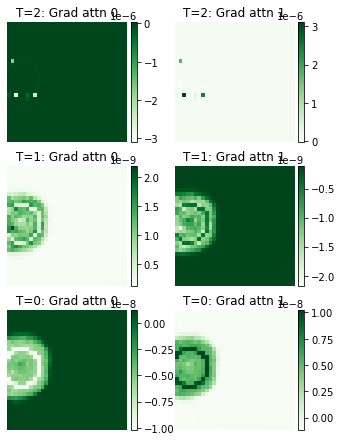

iter 1200 , loss 0.0027346453 , lr 0.00019792618661593412


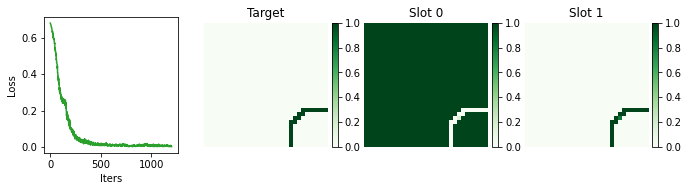

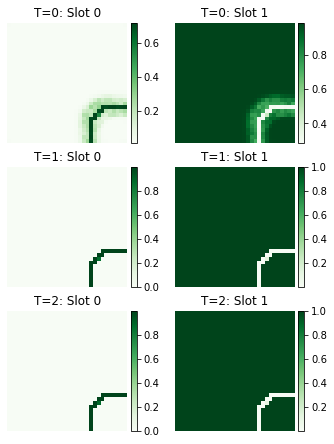

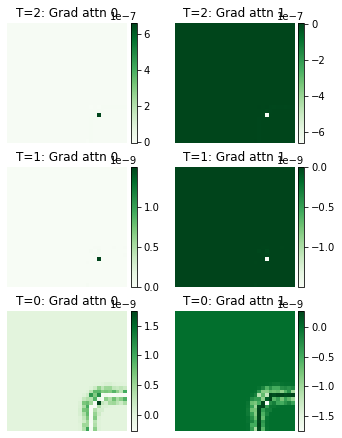

iter 1250 , loss 0.009727745 , lr 0.00019452593319765142


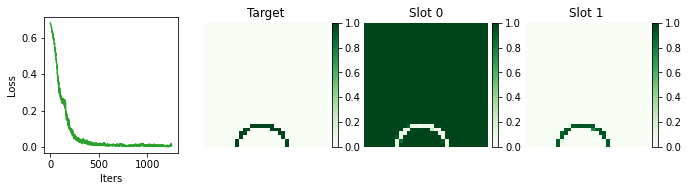

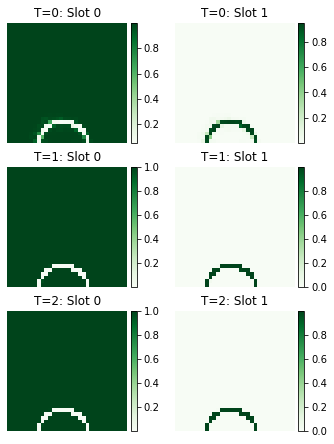

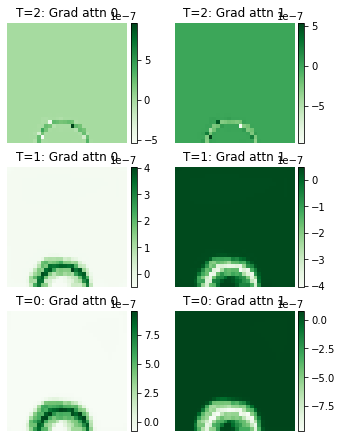

iter 1300 , loss 0.006705726 , lr 0.00019118409409788932


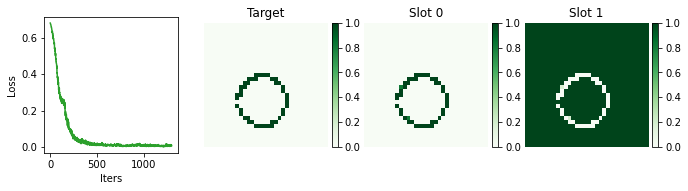

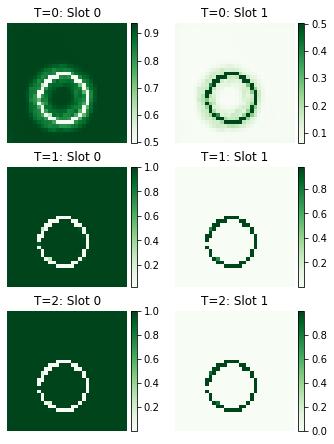

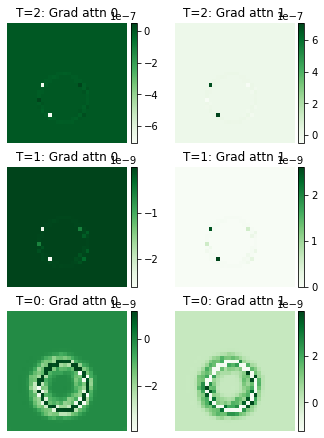

iter 1350 , loss 0.0075792 , lr 0.00018789966579361918


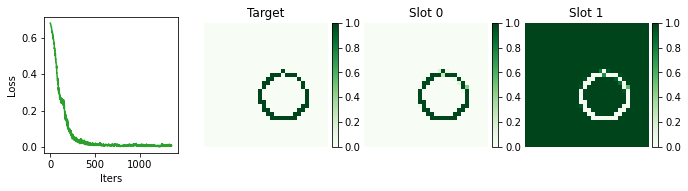

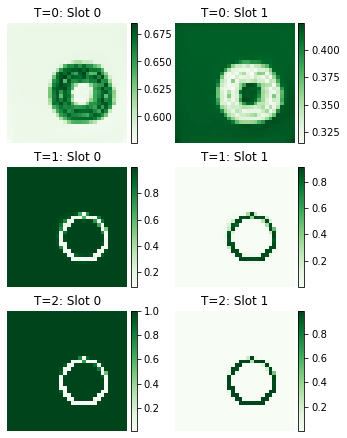

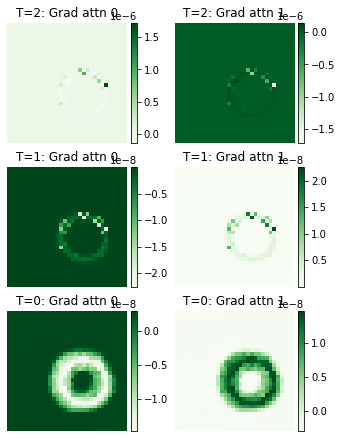

iter 1400 , loss 0.0075341626 , lr 0.00018467166200173744


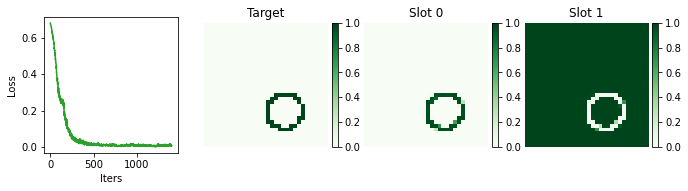

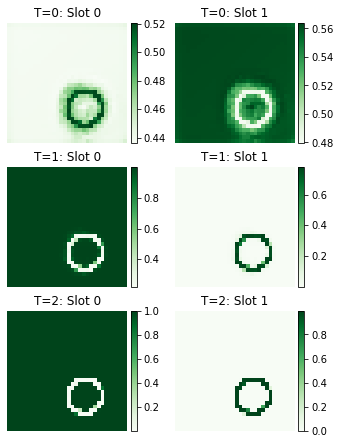

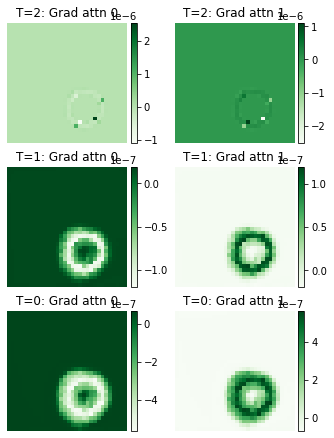

iter 1450 , loss 0.007349968 , lr 0.00018149911338289387


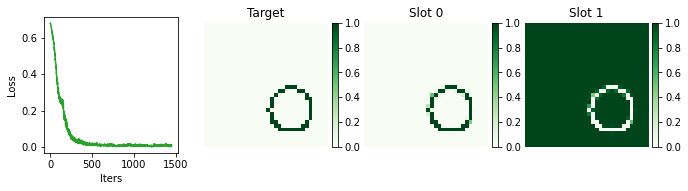

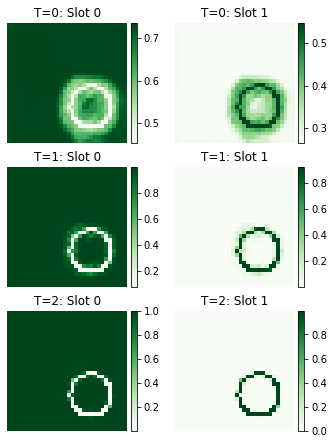

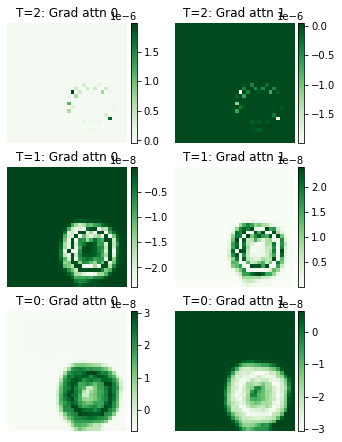

iter 1500 , loss 0.0044311346 , lr 0.00017838106725040815


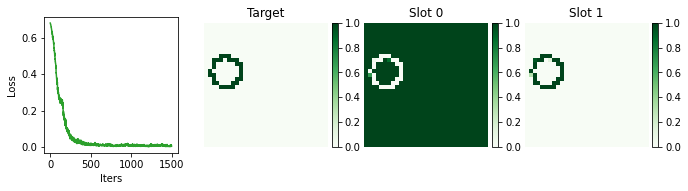

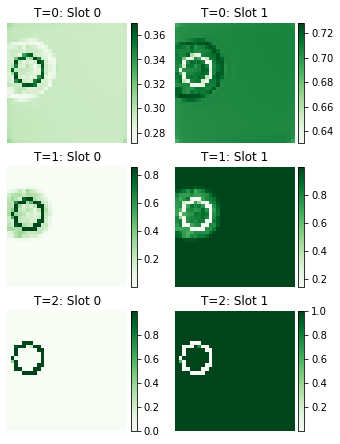

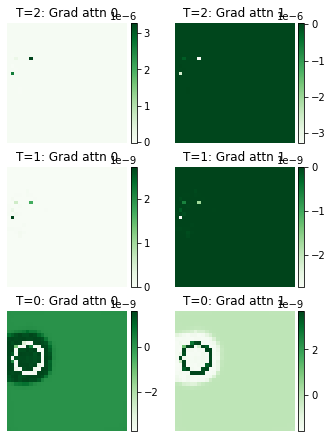

iter 1550 , loss 0.0033258786 , lr 0.00017531658728418682


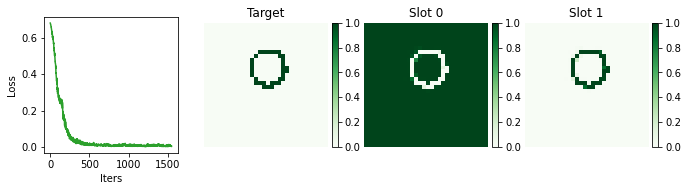

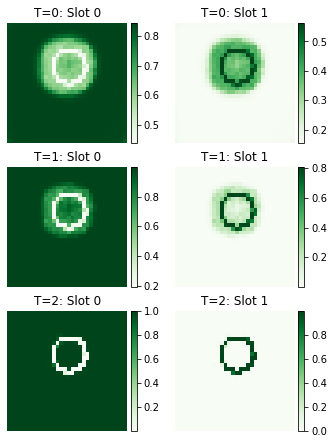

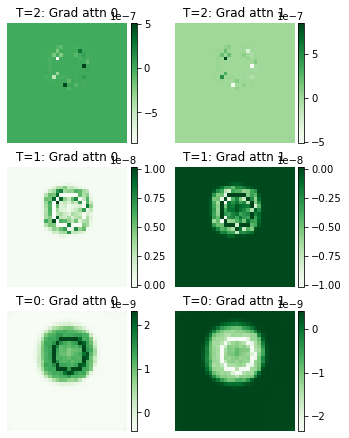

iter 1600 , loss 0.0045940634 , lr 0.00017230475324955523


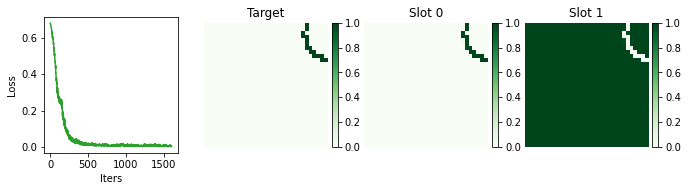

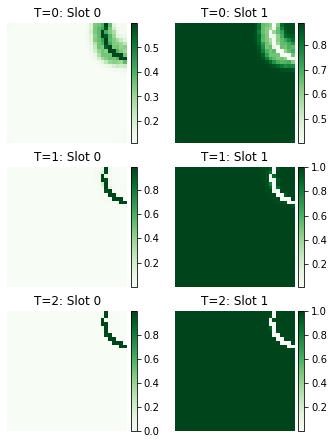

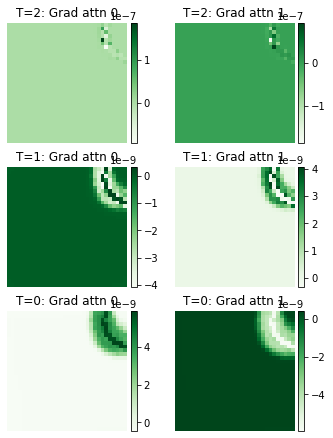

iter 1650 , loss 0.0036588283 , lr 0.0001693446607209197


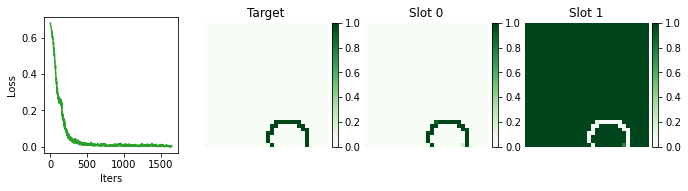

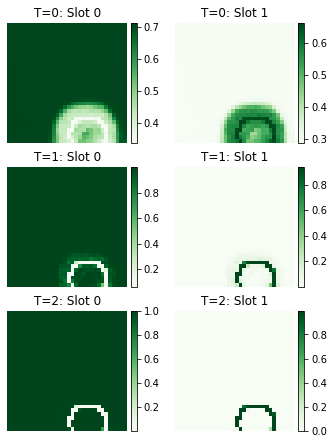

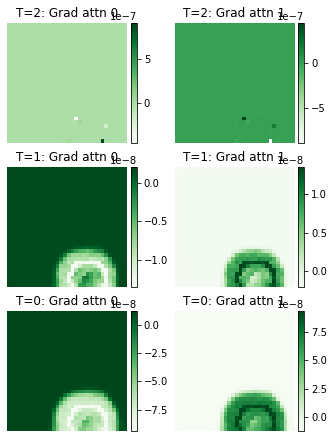

iter 1700 , loss 0.0039632474 , lr 0.00016643542081017676


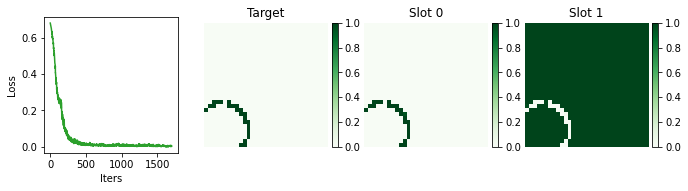

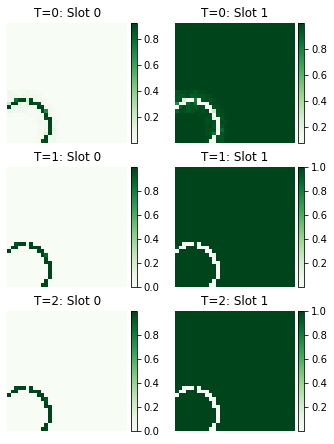

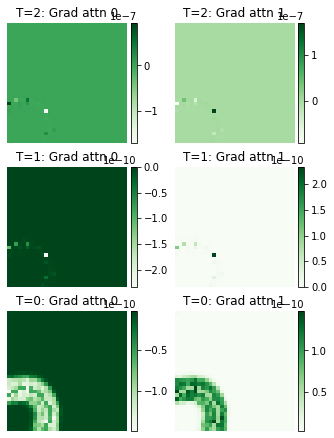

iter 1750 , loss 0.003817366 , lr 0.00016357615989978863


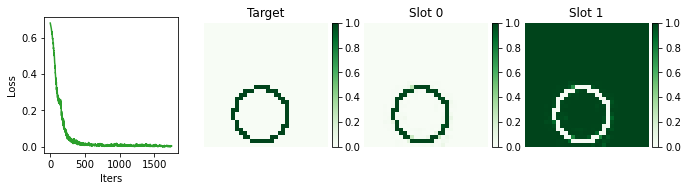

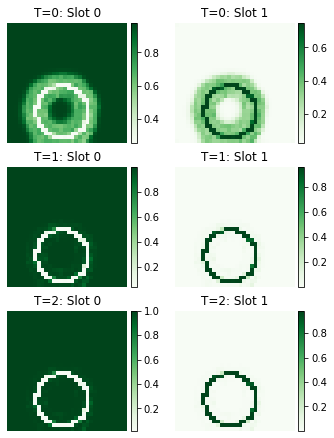

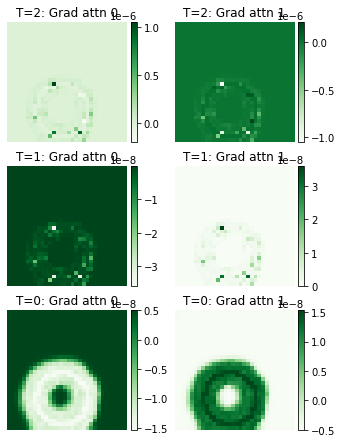

iter 1800 , loss 0.0027571854 , lr 0.00016076601938044396


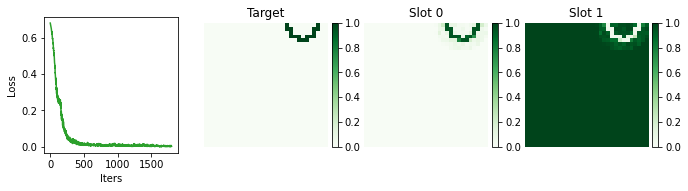

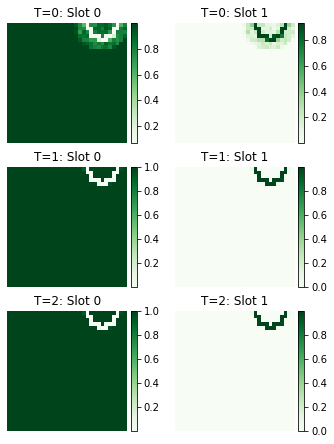

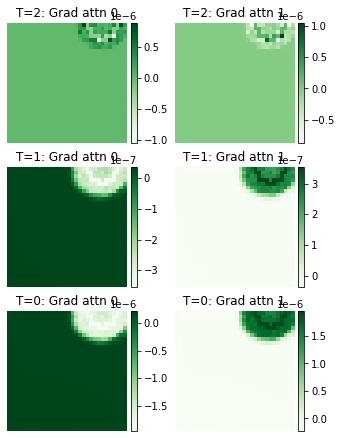

iter 1850 , loss 0.0039035655 , lr 0.00015800415539322536


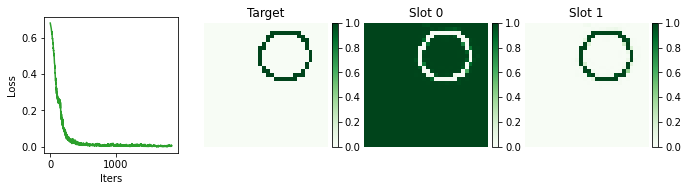

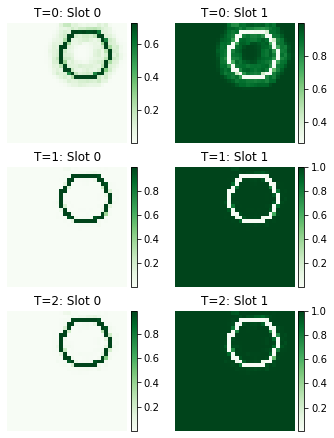

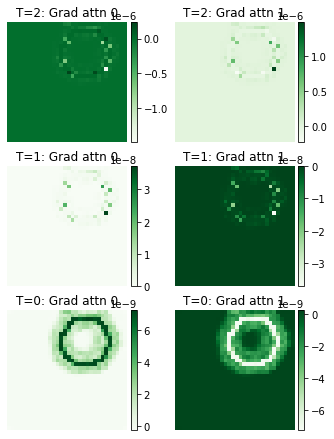

iter 1900 , loss 0.0019263828 , lr 0.00015528973857620662


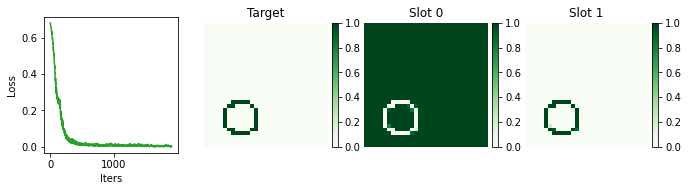

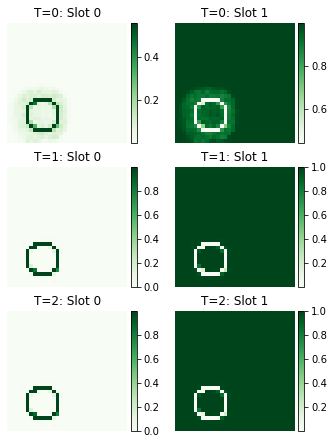

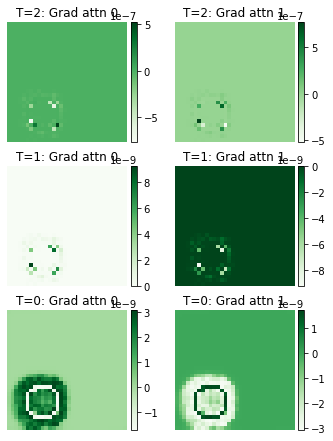

In [ ]:
bs = 256
device='cuda:0'

model = SlotAttentionPosEmbed(k_slots=k_slots,device=device).to(device)

model,L = train(model, 2001,bs=bs,device=device)

## Debugging below

In [ ]:
model = SlotAttentionPosEmbed(k_slots=k_slots,device=device).to(device)

In [ ]:
bs=5

In [ ]:
Ntrain=1

opt = torch.optim.Adam(model.parameters(), 3e-4)
model.train()
losses = []

for i in range(Ntrain):

    X, Y, mask = make_batch(N_events=bs, N_clusters=max_n_rings,device=device)

    queries, att = model(X)

    
    with torch.no_grad():
        indices = hungarian_matching(att,mask,bs,model.k_slots,max_n_rings,nPixels)
    
    # Apply the sorting to the predict
    indices=indices.to(device)
    
    slots_sorted = torch.cat([att[torch.arange(bs).to(device),indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    
    flat_mask = mask.reshape(-1,max_n_rings, nPixels*nPixels)
    rings_sorted = torch.cat([flat_mask[torch.arange(bs).to(device),indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    
    # Calculate the loss
    loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()
    
    loss.backward()
    opt.step()
    opt.zero_grad()

    losses.append(float(loss))

    if i % 25 == 0:
        print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])

        iEvt = 0
        att_img = att[iEvt].reshape(model.k_slots,nPixels,nPixels)
        plot_kslots(losses, 
                    mask[iEvt].sum(axis=0).detach().cpu().numpy(), 
                    att_img.detach().cpu().numpy(),
                    k_slots, color='C2',cmap='Greens')

In [ ]:
flat_mask[torch.arange(bs),indices[:,1,0]].unsqueeze(1)

In [ ]:
rings_sorted = torch.cat([flat_mask[torch.arange(bs),indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)


In [ ]:
indices

In [ ]:
model.gradients

In [ ]:
flat_mask = mask.reshape(-1,max_n_rings, nPixels*nPixels)
flat_mask.shape

In [ ]:
slots_sorted.shape

In [ ]:
rings_sorted.shape

In [ ]:
loss.backward()

In [ ]:
# loss.backward()

In [ ]:
plot_kslots_grads(model.gradients,0)

In [ ]:
pairwise_cost_all.mean(axis=-1).reshape(3,2)

In [ ]:
with torch.no_grad():
    pairwise_cost_all = F.binary_cross_entropy(att_ext,mask_ext,reduction='none')

In [ ]:
ri,ci

In [ ]:
pi_img = pairwise_cost_all.reshape(3,2,nPixels,nPixels)

fig, ax = plt.subplots(3,2,figsize=(2.5*2,2.25*3))

for i in range(3):
    for j in range(2):
        im = ax[i,j].imshow(pi_img[i,j].detach().cpu().numpy())
          
        divider = make_axes_locatable(ax[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
 
        ax[i,j].set_title(f'slot {i}, ring {j}: L={pi_img[i,j].mean():.3f}')

        ax[i,j].axis('off')
        
plt.show()

In [ ]:
pairwise_cost_all

In [ ]:
iEvt=0
cmap='Greens'

fig,axs = plt.subplots(2,k_slots,figsize=(2.5*k_slots,4.75))

for i,ax in enumerate(axs[0][0:max_n_rings]):

    im = ax.imshow(mask[0,i].detach().cpu(),cmap=cmap,vmin=0,vmax=1)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax.set_title(f'mask {i}')

    ax.axis('off')

axs[0,max_n_rings].axis('off')
    
    
for i,ax in enumerate(axs[1]):

    im = ax.imshow(att[0,i].reshape(nPixels,nPixels).detach().cpu(),cmap=cmap,vmin=0,vmax=1)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax.set_title(f'slot {i}')

    ax.axis('off')
    
plt.show()